# Power Skill Extensions - Leading Technology Transformation - Applied Machine Learning - IA Generativa com Opt e Stable Diffusion


### Profs. Ahirton Lopes e Felipe Teodoro



In [11]:
!nvidia-smi

Sat Feb  8 19:12:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             28W /   70W |   11470MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
# Imports

!pip install --upgrade torch
!pip install --upgrade tensorflow
!pip install --upgrade jax
!pip install --upgrade keras-nlp
!pip install --upgrade keras-cv
!pip install --upgrade keras

In [13]:
#@title Seleção de backend e utilitários de exibição [executar]
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def big_print(a,b):
  html = '<div style="font-size: 18pt; font-family: monospace">{}{}</div>'.format(a, b)
  display(HTML(html))
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

backend = 'jax' # @param ["jax", "tensorflow", "torch"]

## Verificando backend e versão do Keras

In [14]:
import math, os, random
os.environ['KERAS_BACKEND'] = backend

import keras
import keras_cv
import keras_nlp

backend = keras.config.backend()
big_print('\u2B50 ', 'Keras version '+keras.version())
big_print('\u2B50 ', 'Running on '+backend.upper())

<hr/>

# <img src="https://keras.io/img/k-logo.png" height="80pt" align="center"/> Keras 3: carregando e executando um modelo Keras NLP

# Demo - KerasNLP - Introdução a LLMs e Modelos

## Testando o modelo OPT

OPT é um modelo LLM causal o qual tem o objetivo de continuar o texto a partir do prompt de input.

In [15]:
# modelo via KerasNLP

nlp_model = keras_nlp.models.OPTCausalLM.from_preset("opt_125m_en")
nlp_model.compile(sampler=keras_nlp.samplers.ContrastiveSampler())

## Prompt

In [16]:
prompt = "Hi, I'm a {} machine learning developer. \
          What are you working on? What are your biggest interests right now?".format(backend.upper()) # modificar de acordo com o exemplo
response = nlp_model.generate(prompt, max_length=57)
response = response.replace(prompt, '')
big_print("\U0001F64B ",prompt)
big_print("\U0001F916 ",response)

# **Stable Diffusion** 🎨
*...usando `🧨diffusers`*

Stable Diffusion é um modelo de difusão latente de texto para imagem criado pelos pesquisadores e engenheiros da [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) e [LAION](https://laion.ai/). Ele é treinado em imagens 512x512 de um subconjunto do banco de dados LAION-5B.  

Este modelo usa um codificador de texto CLIP ViT-L/14 congelado para condicionar o modelo em prompts de texto. Com seu codificador de texto de 860M UNet e 123M, o modelo é relativamente leve e pode ser executado em muitas GPUs, mesmo os modelos voltados para consumidores comuns. Consulte o seguinte [link](https://huggingface.co/CompVis/stable-diffusion) para obter mais informações sobre o modelo.

Este notebook visa te ajudar a iniciar no uso de Stabble Diffusion via as bibliotecas 🤗 Hugging Face e [🧨 Diffusers](https://github.com/huggingface/diffusers).

Vamos começar!

## O que é Stable Diffusion?

Agora, vamos para a parte teórica de Stable Diffusion 👩‍🎓.

Stable Diffusion é baseada em um tipo particular de modelo de difusão chamado Difusão Latente, proposto no paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



Os modelos gerais de difusão são sistemas de aprendizado de máquina treinados para *remover o ruído* gaussiano aleatório passo a passo (denoising), para chegar a uma amostra de interesse, como uma *imagem*. Para uma visão geral mais detalhada de como eles funcionam, verifique [esse colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Os modelos de difusão demonstraram alcançar resultados de ponta para gerar dados de imagem. Mas uma desvantagem dos modelos de difusão é que o processo de redução de ruído reverso é lento. Além disso, esses modelos consomem muita memória porque operam em espaço de pixel, o que se torna excessivamente caro ao gerar imagens de alta resolução. Portanto, é um desafio treinar esses modelos e também usá-los para inferência.



<br>

A difusão latente pode reduzir a memória e a complexidade computacional aplicando o processo de difusão em um espaço _latente_ dimensional inferior, em vez de usar o espaço de pixel real. Esta é a principal diferença entre os modelos de difusão padrão e de difusão latente: **na difusão latente, o modelo é treinado para gerar representações latentes (comprimidas) das imagens.**

Existem três componentes principais na difusão latente.

1. Um codificador automático (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. Um codificador de texto, *por exemplo* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. O Autoencoder (VAE)**

O modelo VAE tem duas partes, um codificador e um decodificador. O codificador é usado para converter a imagem em uma representação latente de baixa dimensão, que servirá como entrada para o modelo *U-Net*.
O decodificador, ao contrário, transforma a representação latente de volta em imagem.

  Durante o _treinamento_ de difusão latente, o codificador é usado para obter as representações latentes (_latentes_) das imagens para o processo de difusão direta, que aplica cada vez mais ruído a cada etapa. Durante a _inferência_, os latentes sem ruído gerados pelo processo de difusão reversa são convertidos novamente em imagens usando o decodificador VAE. Como veremos durante a inferência, **precisamos apenas do decodificador VAE**.

**2. A U-Net**

A U-Net possui uma parte codificadora e uma parte decodificadora, ambas compostas por blocos ResNet.

O codificador comprime uma representação de imagem em uma representação de imagem de resolução mais baixa e o decodificador decodifica a representação de imagem de resolução mais baixa de volta para a representação de imagem original de resolução mais alta que é supostamente menos ruidosa.

Mais especificamente, a saída U-Net prevê o ruído residual que pode ser usado para calcular a representação de imagem sem ruído prevista.

Para evitar que o U-Net perca informações importantes durante o downsampling, geralmente são adicionadas conexões de atalho entre os ResNets de downsampling do codificador e os ResNets de upsampling do decodificador.

Além disso, a difusão estável U-Net é capaz de condicionar sua saída em incorporações de texto por meio de camadas de atenção cruzada. As camadas de atenção cruzada são adicionadas à parte do codificador e do decodificador da U-Net, geralmente entre os blocos ResNet.

**3. O codificador de texto**

O codificador de texto é responsável por transformar o prompt de entrada, *por exemplo* "Um astronauta andando a cavalo" em um espaço de incorporação que pode ser entendido pela U-Net. Geralmente é um codificador *baseado em transformador* simples que mapeia uma sequência de tokens de entrada para uma sequência de incorporações de texto latentes.

Inspirado por [Imagen](https://imagen.research.google/), Stable Diffusion **não** treina o codificador de texto durante o treinamento e simplesmente usa um codificador de texto já treinado do CLIP, [CLIPTextModel](https:/ /huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Por que stable diffusion é rápida e eficiente?**

Uma vez que a U-Net dos modelos de difusão latente opera em um espaço de baixa dimensão, ela reduz bastante os requisitos de memória e computação em comparação com os modelos de difusão de espaço de pixel. Por exemplo, o autoencoder usado em Stable Diffusion tem um fator de redução de 8. Isso significa que uma imagem de forma `(3, 512, 512)` torna-se `(3, 64, 64)` no espaço latente, o que requer `8 × 8 = 64` vezes menos memória.

É por isso que é possível gerar imagens `512 × 512` tão rapidamente, mesmo em GPUs Colab de 16 GB!

**Stable Diffusion durante inferência**

Juntando tudo, vamos agora dar uma olhada mais de perto em como o modelo funciona na inferência ilustrando o fluxo lógico.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

O modelo de stable diffusion usa uma semente latente e um prompt de texto como entrada. A semente latente é então usada para gerar representações aleatórias de imagens latentes de tamanho $64 \times 64$ onde, conforme o prompt de texto, é transformado em incorporações de texto de tamanho $77 \times 768$ por meio do codificador de texto do CLIP.

Em seguida, o U-Net iterativamente *reduz* as representações de imagens latentes aleatórias enquanto é condicionado nas incorporações de texto. A saída do U-Net, sendo o ruído residual, é usada para calcular uma representação de imagem latente sem ruído por meio de um algoritmo de escalonamento. Muitos algoritmos de agendadores diferentes podem ser usados para esse cálculo, cada um com seus prós e contras. Para difusão estável, recomendamos o uso de um dos seguintes:

- [Agendador PNDM](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (usado por padrão).
- [Agendador K-LMS](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Agendador discreto Heun](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [Agendador de várias etapas do DPM Solver](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). Este agendador é capaz de alcançar grande qualidade em menos passos. Você pode tentar com 25 em vez do padrão 50!

A teoria sobre como a função do algoritmo do agendador está fora do escopo deste notebook, mas, em suma, deve-se lembrar que eles calculam a representação de imagem sem ruído prevista a partir da representação de ruído anterior e do resíduo de ruído previsto.
Para obter mais informações, recomendamos consultar [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

O processo de *redução de ruído* é repetido *em torno de* 50 vezes para recuperar passo a passo as melhores representações de imagens latentes.
Depois de concluída, a representação da imagem latente é decodificada pela parte do decodificador do codificador automático variacional.

In [17]:
#@title Seleção de backend e utilitários de exibição [executar-me]
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def big_print(a,b):
  html = '<div style="font-size: 18pt; font-family: monospace">{}{}</div>'.format(a, b)
  display(HTML(html))
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

backend = 'jax' # @param ["jax", "tensorflow", "torch"]

## Verificando backend e versão do Keras

In [18]:
import math, os, random
os.environ['KERAS_BACKEND'] = backend

import keras
import keras_cv
import keras_nlp

backend = keras.config.backend()
big_print('\u2B50 ', 'Keras version '+keras.version())
big_print('\u2B50 ', 'Running on '+backend.upper())

<hr/>

# <img src="https://keras.io/img/k-logo.png" height="80pt" align="center"/> Keras 3: Carregando e executando um modelo do Keras-CV

O modelo de difusão estável gera imagens a partir de prompts de texto.

In [19]:
stable_diffusion = keras_cv.models.StableDiffusion()
if backend=="torch":
  stable_diffusion.jit_compile = False # work in progress on PyTorch...

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step


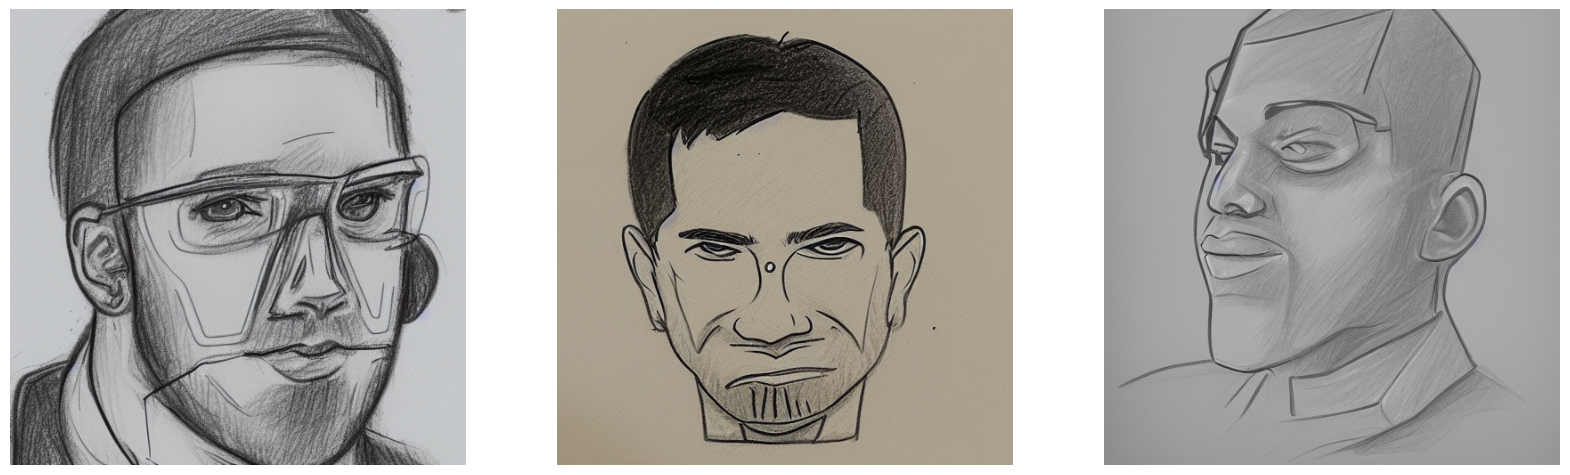

In [20]:
prompt = "A refined pencil sketch of a {} machine learning developer.".format(backend.upper()) # modificar de acordo com o exemplo
images = stable_diffusion.text_to_image(prompt, batch_size=3)

big_print("\U0001F4DD	 ",prompt)
plot_images(images)